In [3]:
from utils.config import Config
from model.fasterrcnn import FasterRCNNTrainer, FasterRCNN
import tensorflow as tf
from utils.data import Dataset
import matplotlib.pyplot as plt

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
%matplotlib notebook

In [5]:
config = Config()
config._parse({})

======user config========
{'max_size': 1000,
 'min_size': 600,
 'roi_sigma': 1.0,
 'rpn_sigma': 3.0,
 'voc_data_dir': 'D:/DataClinic/simple-faster-rcnn-pytorch/VOCdevkit/VOC2007/'}
==========end============


In [6]:
dataset = Dataset(config)

In [82]:
VOC_BBOX_LABEL_NAMES = (
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
    'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')


In [7]:
from model.rpn import RegionProposalNetwork

In [8]:
rpn = RegionProposalNetwork(ratios=[0.5, 1, 2], anchor_scales=[8, 16, 32], feat_stride=16)

In [29]:
img, bboxes, labels, scale = dataset[233]
img_size = img.shape[:2]
x = tf.convert_to_tensor(img, dtype=tf.float32)
x = tf.expand_dims(x, axis=0)

In [30]:
feature_map, conv_cls_bboxes, rpn_scores, rois, anchor = rpn(x)

In [26]:
for x in (feature_map, conv_cls_bboxes, rpn_scores, rois, anchor):
    print('shape:', x.shape, 'max:', tf.reduce_max(x).numpy(), 'min:', tf.reduce_min(x).numpy())

shape: (1, 38, 50, 256) max: 0.007985776 min: 0.0
shape: (1, 38, 50, 36) max: 0.0074189184 min: -0.0053305104
shape: (1, 17100, 2) max: 0.5032469 min: 0.4967531
shape: (2000, 4) max: 800.0 min: 0.0
shape: (17100, 4) max: 1154.0387 min: -354.03867


In [13]:
from utils.anchor import AnchorTargetCreator

In [14]:
anchor_target_creator = AnchorTargetCreator(n_sample=256, pos_iou_thresh=0.7, neg_iou_thresh=0.3, pos_ratio=0.5,)

In [16]:
gt_rpn_loc, gt_rpn_label = anchor_target_creator(bboxes, anchor, img_size)

In [46]:
for x in (gt_rpn_loc, gt_rpn_label):
    print('shape:', x.shape, 'max:', tf.reduce_max(x).numpy(), 'min:', tf.reduce_min(x).numpy())

shape: (17100, 4) max: 4.110058 min: -3.9244435
shape: (17100,) max: 1 min: -1


In [49]:
def _smooth_l1_loss(pred_loc, gt_loc, in_weight):
    # pred_loc, gt_loc, in_weight
    x = tf.reshape(pred_loc, [-1, 4])
    diff = in_weight * (x - gt_loc)
    abs_diff = tf.math.abs(diff)
    flag = tf.cast(abs_diff.numpy() < 1., dtype=tf.float32)
    y = (flag * (0.5) * (diff ** 2) + (1 - flag) * (abs_diff - 0.5))
    return tf.reduce_sum(y)

In [50]:
def _fast_rcnn_loc_loss(pred_loc, gt_loc, gt_label):
    """
    :param pred_loc: 1,38,50,36
    :param gt_loc: 17100,4
    :param gt_label: 17100
    """
    in_weight = np.zeros(gt_loc.shape)
    idx = (gt_label >= 0).reshape([-1, 1])
    idx = np.stack([idx, idx, idx, idx], axis=1)
    idx = np.reshape(idx, in_weight.shape)
    in_weight[idx] = 1
    loc_loss = _smooth_l1_loss(pred_loc, gt_loc, in_weight)
    # Normalize by total number of negtive and positive rois.
    loc_loss /= ((gt_label >= 0).sum())  # ignore gt_label==-1 for rpn_loss
    return loc_loss

In [52]:
_fast_rcnn_loc_loss(conv_cls_bboxes, gt_rpn_loc, gt_rpn_label)

<tf.Tensor: shape=(), dtype=float32, numpy=1.4882807>

In [53]:
from utils.data import vis

<IPython.core.display.Javascript object>


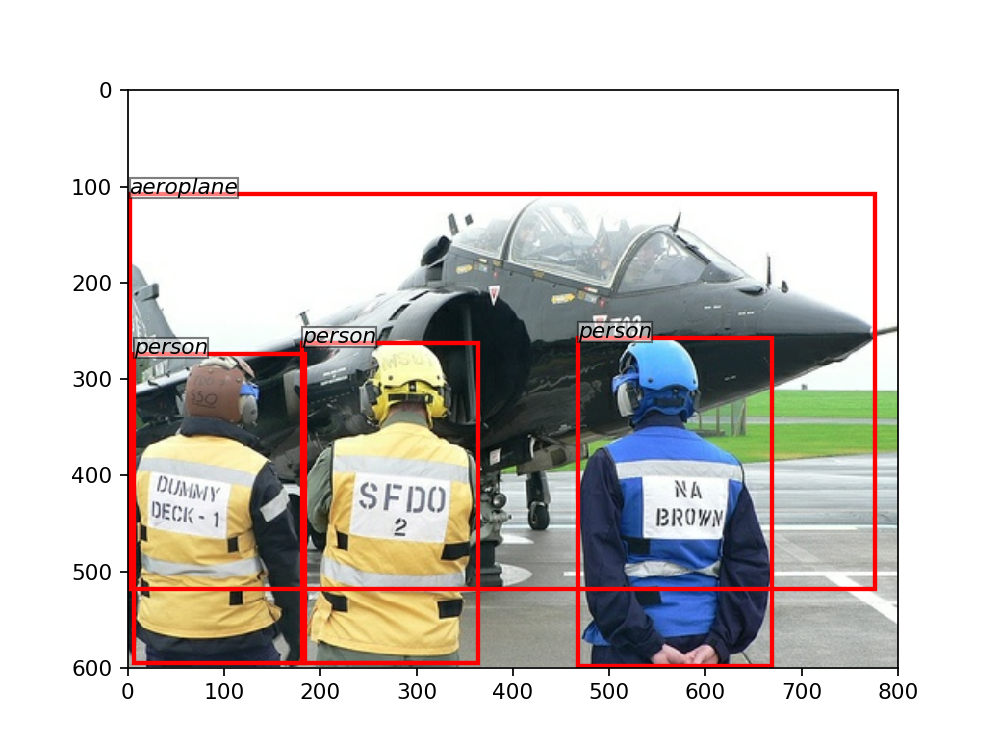

In [54]:
vis(img, bboxes, labels, scale)

In [31]:
training_index = gt_rpn_label != -1

assert len(gt_rpn_loc[training_index]) == 256

training_anchor = anchor[training_index]
training_conv_cls_bboxes = tf.reshape(conv_cls_bboxes,[-1, 4])[training_index]
training_rpn_scores = tf.reshape(rpn_scores,[-1, 2])[training_index]

In [32]:
for x in (training_anchor, training_conv_cls_bboxes, training_rpn_scores):
    print('shape:', x.shape, 'max:', tf.reduce_max(x).numpy(), 'min:', tf.reduce_min(x).numpy())

shape: (256, 4) max: 797.01935 min: 2.980667
shape: (256, 4) max: 0.005466518 min: -0.00420832
shape: (256, 2) max: 0.5022443 min: 0.49775568


In [55]:
img = (img + 1) / 2.

<IPython.core.display.Javascript object>


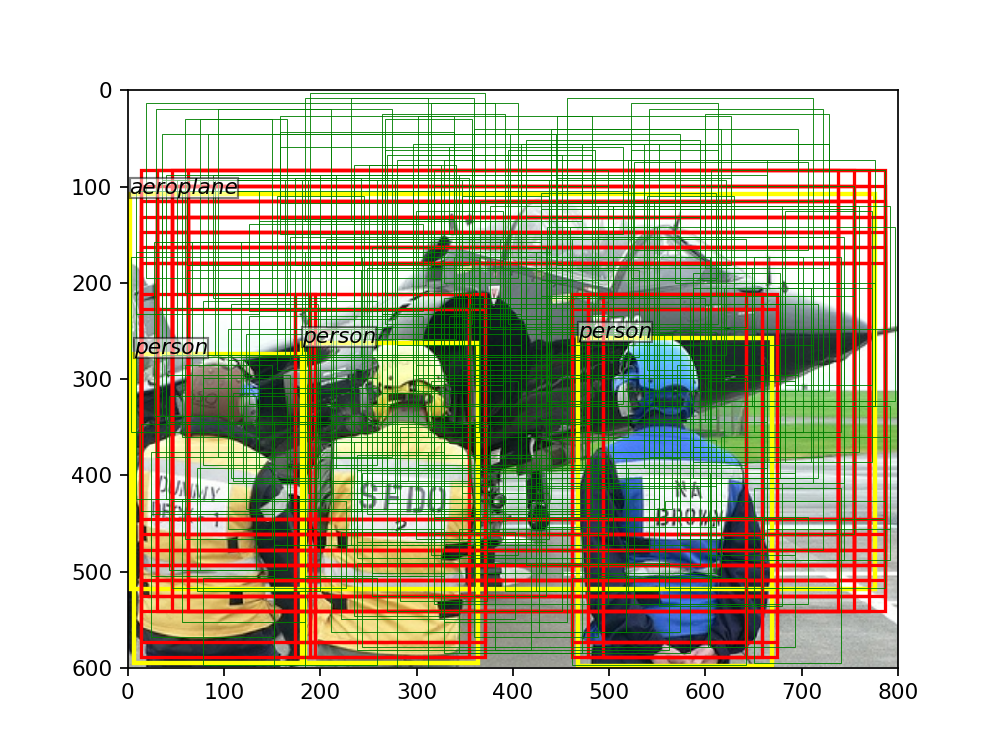

In [83]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)

for i in range(len(bboxes)):
    y1 = bboxes[i][0]
    x1 = bboxes[i][1]
    y2 = bboxes[i][2]
    x2 = bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[labels[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})


pos_anchor = anchor[gt_rpn_label == 1]
for i in range(len(pos_anchor)):
    y1 = pos_anchor[i][0]
    x1 = pos_anchor[i][1]
    y2 = pos_anchor[i][2]
    x2 = pos_anchor[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

neg_anchor = anchor[gt_rpn_label == 0]
for i in range(len(neg_anchor)):
    y1 = neg_anchor[i][0]
    x1 = neg_anchor[i][1]
    y2 = neg_anchor[i][2]
    x2 = neg_anchor[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='green', linewidth=0.4))

In [68]:
from utils.anchor import loc2bbox

In [70]:
rpn_bbox = loc2bbox(anchor, conv_cls_bboxes)

In [76]:
tf.reshape(conv_cls_bboxes, [-1, 4])[1]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.00061759, -0.0004727 ,  0.00088904,  0.00097064], dtype=float32)>

In [72]:
rpn_bbox[1]

array([ -82.70196, -173.36626,   98.47837,  189.02397], dtype=float32)

In [73]:
anchor[1]

array([ -82.50967, -173.01933,   98.50967,  189.01933], dtype=float32)

<IPython.core.display.Javascript object>


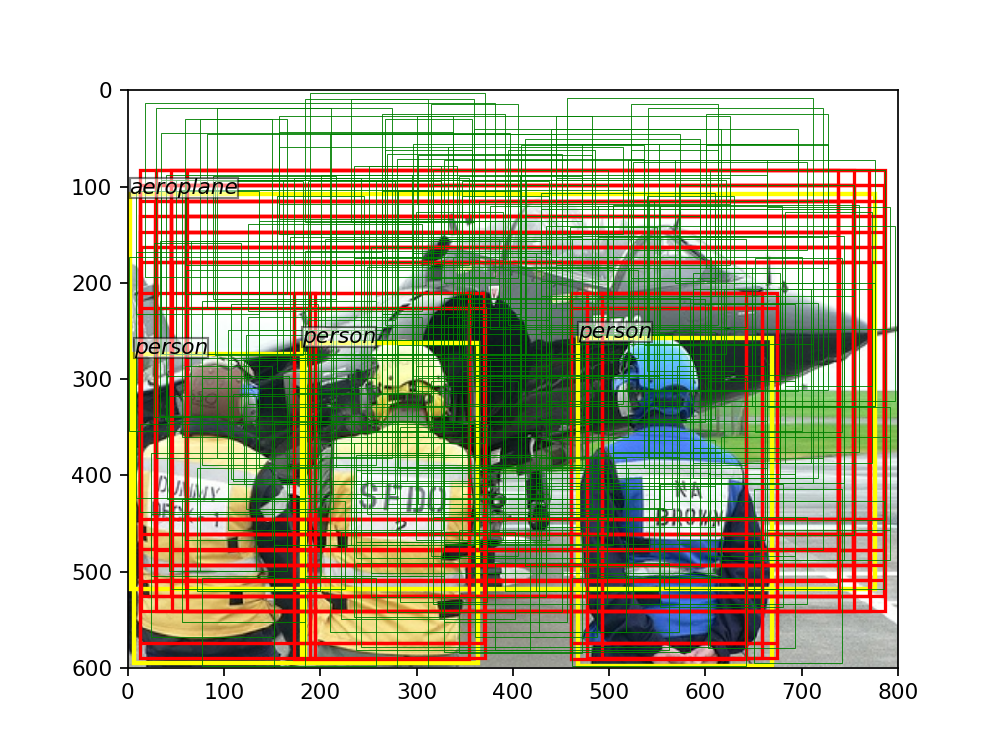

In [84]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)

for i in range(len(bboxes)):
    y1 = bboxes[i][0]
    x1 = bboxes[i][1]
    y2 = bboxes[i][2]
    x2 = bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[labels[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})

pos_rpn_bbox = rpn_bbox[gt_rpn_label == 1]
for i in range(len(pos_anchor)):
    y1 = pos_rpn_bbox[i][0]
    x1 = pos_rpn_bbox[i][1]
    y2 = pos_rpn_bbox[i][2]
    x2 = pos_rpn_bbox[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

neg_rpn_bbox = rpn_bbox[gt_rpn_label == 0]
for i in range(len(neg_anchor)):
    y1 = neg_rpn_bbox[i][0]
    x1 = neg_rpn_bbox[i][1]
    y2 = neg_rpn_bbox[i][2]
    x2 = neg_rpn_bbox[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='green', linewidth=0.4))

In [85]:
rpn_target_bbox = loc2bbox(anchor, gt_rpn_loc)

<IPython.core.display.Javascript object>


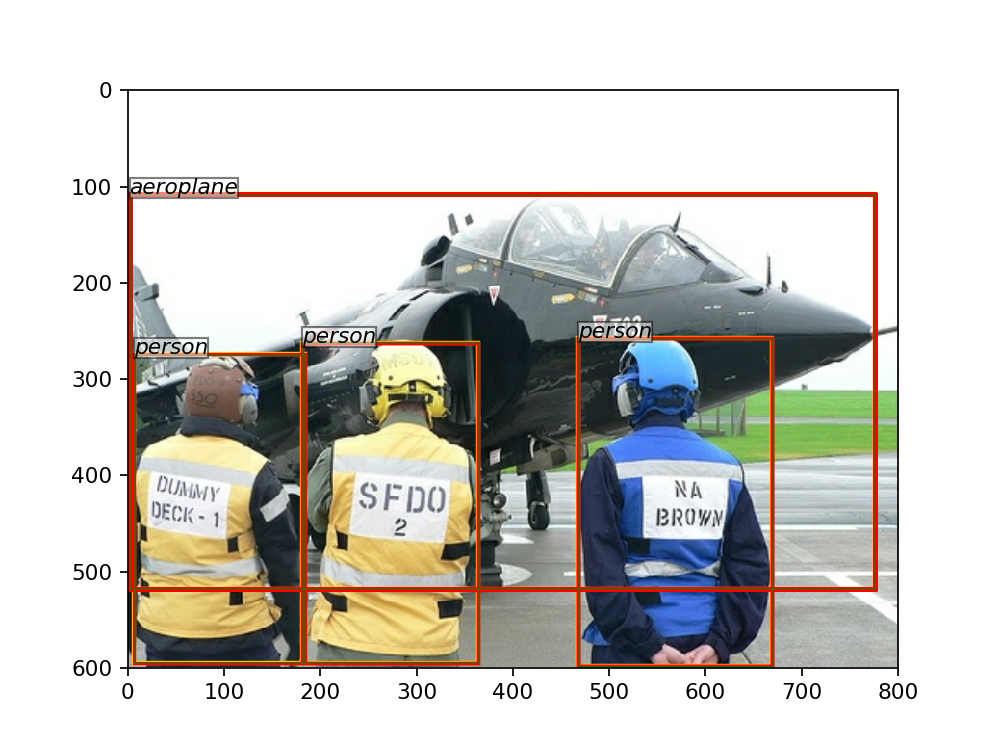

In [86]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)

for i in range(len(bboxes)):
    y1 = bboxes[i][0]
    x1 = bboxes[i][1]
    y2 = bboxes[i][2]
    x2 = bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[labels[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})

pos_rpn_target_bbox = rpn_target_bbox[gt_rpn_label == 1]
for i in range(len(pos_anchor)):
    y1 = pos_rpn_target_bbox[i][0]
    x1 = pos_rpn_target_bbox[i][1]
    y2 = pos_rpn_target_bbox[i][2]
    x2 = pos_rpn_target_bbox[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

neg_rpn_target_bbox = rpn_target_bbox[gt_rpn_label == 0]
for i in range(len(neg_anchor)):
    y1 = neg_rpn_target_bbox[i][0]
    x1 = neg_rpn_target_bbox[i][1]
    y2 = neg_rpn_target_bbox[i][2]
    x2 = neg_rpn_target_bbox[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='green', linewidth=0.4))

In [87]:
gt_rpn_label[training_index]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [90]:
rpn_scores[0][training_index]

<tf.Tensor: shape=(256, 2), dtype=float32, numpy=
array([[0.49922687, 0.50077313],
       [0.49892914, 0.50107086],
       [0.4989173 , 0.50108266],
       [0.49926564, 0.5007343 ],
       [0.49922946, 0.5007705 ],
       [0.4992529 , 0.50074714],
       [0.49890935, 0.50109065],
       [0.4989229 , 0.5010771 ],
       [0.5001817 , 0.4998183 ],
       [0.49923974, 0.50076026],
       [0.49928093, 0.5007191 ],
       [0.49929458, 0.5007054 ],
       [0.49940518, 0.5005948 ],
       [0.49929032, 0.5007097 ],
       [0.49929512, 0.5007049 ],
       [0.49939284, 0.50060713],
       [0.49890825, 0.5010918 ],
       [0.4993088 , 0.50069124],
       [0.4989028 , 0.5010972 ],
       [0.49924698, 0.500753  ],
       [0.5001898 , 0.4998102 ],
       [0.49930772, 0.50069225],
       [0.50018656, 0.49981344],
       [0.50028795, 0.49971205],
       [0.49879983, 0.50120014],
       [0.49922994, 0.50077003],
       [0.49982008, 0.50017995],
       [0.49877197, 0.50122803],
       [0.4989249 , 0.5010

In [91]:
tf.keras.losses.SparseCategoricalCrossentropy()(gt_rpn_label[training_index], rpn_scores[0][training_index])

<tf.Tensor: shape=(), dtype=float32, numpy=0.6936431>